# Forecasting Walmart Sales data using ARIMA

Link to the data sheet -> [data.csv](https://docs.google.com/spreadsheets/d/1o2sHCipJgFzB7vH9_rJEm4KNX2a1-5FwuGM_H4HD_ds/edit?usp=sharing).

Download it and save it as `data.csv`
Upload the sheet in the `Files` tab in the left panel

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
import json

from scipy.stats import normaltest, norm, probplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
data = pd.read_csv('/content/data.csv')
data['data'] = data['data'].astype('float32')
data

,year,data
0,1998-Q1,18187.0
1,1998-Q2,20407.0
2,1998-Q3,20495.0
3,1998-Q4,24731.0
4,1999-Q1,20737.0
...,...,...
83,2018-Q4,86579.0
84,2019-Q1,77748.0
85,2019-Q2,82815.0
86,2019-Q3,80583.0


The kurtosis is 15.945817850200669
The p-value is 0.00034467489273931


Text(0.5, 1.0, 'Probplot of data')

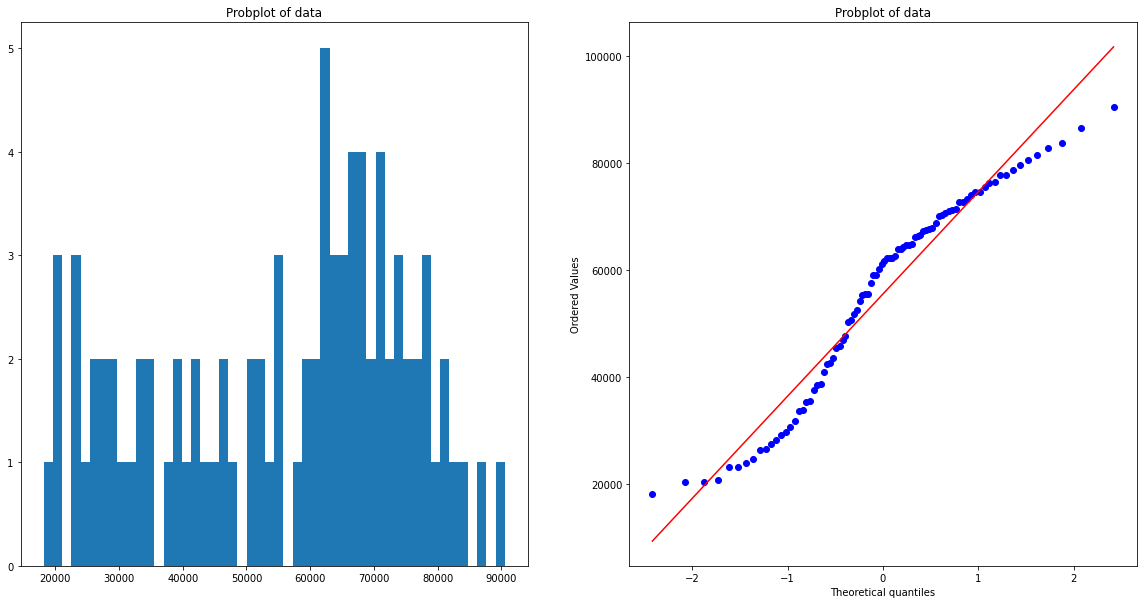

In [ ]:
kurtosis, p_value = normaltest(data['data'])

print("The kurtosis is", kurtosis)
print("The p-value is", p_value)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

axs[0].hist(data['data'],bins=50)
axs[0].set_title('Probplot of data')

prob = probplot(data['data'], dist=norm, plot=axs[1])
axs[1].set_title('Probplot of data')

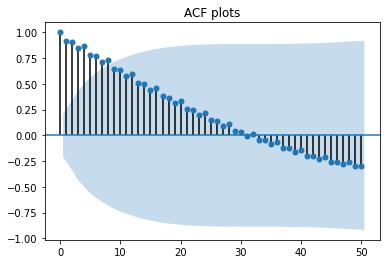

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


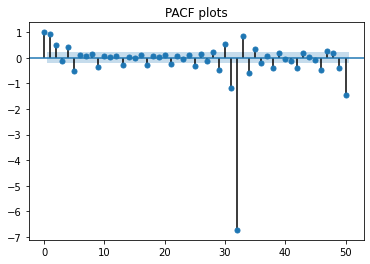

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data['data'], lags=50)
plt.title('ACF plots')
plt.show()

plot_pacf(data['data'], lags=50)
plt.title('PACF plots')
plt.show()

In [ ]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order, days):
    """
    function to evaluate the ARIMA model for a given order (p,d,q)
    
    Parameters
    ---------------
    X : (list)
        List of the time-series data
    arima_order : (tuple)
        Tuple of the parameters p,q and d
    days: (int)
        Number of days of prediction expected from the model
    
    Returns
    --------------
    error: (int)
        Returns the mean absolute error of the actual and predicted values.
    
    """
    
    total_size = int(len(X))
    train_size = int(len(X) * 0.2)
    
    # variable for running fitting the model in cycles of n days.
    size = train_size
    
    # prepare training dataset
    train = [x for x in X[:train_size]]
    
    predictions = []
    actual = []
    
    # Looping till the end of the total size of the data
    while size+days < total_size:
        
        # prepare the test data
        test = [x for x in X[size : size + days]]
        
        # fitting the model on train data
        model = ARIMA(train, order = arima_order)
        model_fit = model.fit(disp = 0)
        
        # predictions from the fitted model for the given number of n days
        forecasts, std_error, pred_interval = model_fit.forecast(days, alpha=0.05)  # The confidence intervals for the forecasts are (1 - alpha) %
        
        # appending the n days predictions to the total predictions
        predictions += list(forecasts)
        
        # appending the n days actual values to the total actual values
        actual += test
        
        # appending the n days actual values to the train data for further fitting of the model
        train += test
        
        size += days
        
    # calculate out of sample error
    mae_error = mean_absolute_error(actual, predictions)
    mse_error = mean_squared_error(actual, predictions)
    
    return mae_error, mse_error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values, days):
    """
    function to evaluate the ARIMA model for different orders of (p,d,q)
    
    Parameters
    ---------------
    dataset : (list)
        List of the time-series data
        
    p_values, d_values, q_values : (list)
        List values of p,q and d values respectively.
        
    days: (int)
        Number of days of prediction expected from the model
    
    Returns
    --------------
    best_cfg: (tuple)
        Returns the tuple of (p,q,d) values which has the least MAE error.
    
    """
        
    best_score, best_cfg, best_model = float("inf"), None, None
    
    # Looping through the p values
    for p in p_values:
        
        # Looping through the q values
        for d in d_values:
            
            for q in q_values:
                
                order = (p,d,q)
                try:
                    # finding the mae of the given order
                    mae, mse = evaluate_arima_model(dataset, order, days)
                    
                    # saving the minimum order and error
                    if mae < best_score:
                        best_score, best_cfg = mae, order
                        
                    print('ARIMA%s MAE = %f, MSE = %f' % (order, mae, mse))
                 
                except:
                    
                    print("Unable to fit", order )
                    continue
                    
    print('Best ARIMA%s MAE = %.3f' % (best_cfg, best_score))
    return best_cfg

In [ ]:
# evaluate parameters
p_values = [0, 1, 2 ]
d_values = [0, 1, 2 ]
q_values = [0, 1, 2 ]

warnings.filterwarnings("ignore")

days = 1

# Getting the tuple of (p,q,d) with least mean absolute error
best_cfg = evaluate_models(data['data'], p_values, d_values, q_values, days)

ARIMA(0, 0, 0) MAE = 20306.405622, MSE = 446606556.945844
ARIMA(0, 0, 1) MAE = 13429.925576, MSE = 225297078.295307
ARIMA(0, 0, 2) MAE = 6739.006761, MSE = 60671588.407698
ARIMA(0, 1, 0) MAE = 5395.166658, MSE = 39981198.182381
ARIMA(0, 1, 1) MAE = 3621.986257, MSE = 18601950.546625
Unable to fit (0, 1, 2)
ARIMA(0, 2, 0) MAE = 10833.942812, MSE = 139820809.770503
ARIMA(0, 2, 1) MAE = 5464.457568, MSE = 41410679.578051
Unable to fit (0, 2, 2)
ARIMA(1, 0, 0) MAE = 5417.005991, MSE = 42244998.218637
Unable to fit (1, 0, 1)
Unable to fit (1, 0, 2)
ARIMA(1, 1, 0) MAE = 3649.429348, MSE = 18581092.171201
Unable to fit (1, 1, 1)
Unable to fit (1, 1, 2)
ARIMA(1, 2, 0) MAE = 5858.198824, MSE = 38646436.923726
Unable to fit (1, 2, 1)
Unable to fit (1, 2, 2)
Unable to fit (2, 0, 0)
Unable to fit (2, 0, 1)
Unable to fit (2, 0, 2)
ARIMA(2, 1, 0) MAE = 3708.963220, MSE = 18438718.624461
Unable to fit (2, 1, 1)
Unable to fit (2, 1, 2)
ARIMA(2, 2, 0) MAE = 5961.796965, MSE = 39776180.820236
Unable to 

In [ ]:
def prediction(data, best_cfg):
    """
    function for prediction on the test data
    
    Parameters
    --------------
    data: pd.DataFrame
        BAI data
    best_cfg: tuple
        best configuration obtained while evaluating the models
        
    Returns
    ----------------
    data required for plotting the results.
    train_dates: pd.Series
        range of dates used for training
    
    train_data: pd.Series
        data used for training
    
    actual_test: pd.Series
        actual BAI data in the test split
    
    forecast_series: pd.Series
        predicted values by the model
        
    test_dates: pd.Series
        range of dates used for testing
    
    upper_series: pd.Series
        Upper prediction interval limits
    
    lower_series: pd.Series
        Lower prediction interval limits
    
    """
    
    # calculating the total size of the data
    total_size = int(len(data))

    # calculating the train size
    train_size = int(len(data) * 0.2)

    # creating the train data for feeding to the model.
    train = [x for x in data['data'][:train_size]]

    # storing the train data
    history = data['data'][:train_size]

    # variable to store the size of the data moved through.
    size = train_size
    print("Training size", size)
    total_forecast, total_lower, total_upper = [], [], []

    # Looping till the end of the total size of the data
    while size + days <= total_size:

        # Creating the test data for n days
        test = [x for x in data['data'][size: size + days]]

        # Fitting the model
        model = ARIMA(train, order = best_cfg)
        model_fit = model.fit(disp = 0)

        # forecasting the model for n days
        forecast, std_error, pred_interval = model_fit.forecast(days, alpha=0.5)  # The confidence intervals for the forecasts are (1 - alpha) %

        # Appending the forecasts, upper and lower prediction interval limits of the predictions.
        total_forecast += list(forecast)
        total_lower += list(pred_interval[:,0])
        total_upper += list(pred_interval[:,1])

        # Updating the variable
        size += days

        # Updating the train data
        train += test

    # copying the actual test data.
    actual_test = data['data'][train_size:size]
  
    # Printing the summary of the model.
    model_fit.summary()

    # plotting the residual errors
    residuals = pd.DataFrame(model_fit.resid)
    residuals.plot(kind='kde')
    plt.show()
    print(residuals.describe())
    
    # Converting to pandas.Series
    forecast_series = pd.Series(total_forecast, index=actual_test.index)
    lower_series = pd.Series(total_lower, index=actual_test.index)
    upper_series = pd.Series(total_upper, index=actual_test.index)
    
    train_dates = data['year '][:train_size]
    test_dates = data['year '][train_size:size ]
    
    train_data = history

    return train_dates, train_data, test_dates, actual_test, forecast_series, lower_series, upper_series


Training size 17


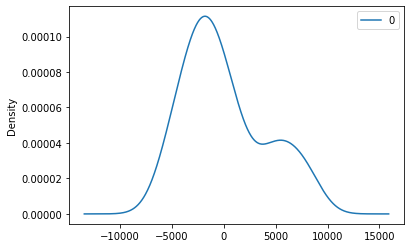

                 0
count    86.000000
mean     40.081435
std    3903.679422
min   -6102.142366
25%   -2695.469559
50%    -947.686747
75%    1819.073521
max    8554.099100


In [ ]:
train_dates, train_data, test_dates, actual_test, forecast_series, lower_series, upper_series = prediction( data, best_cfg )

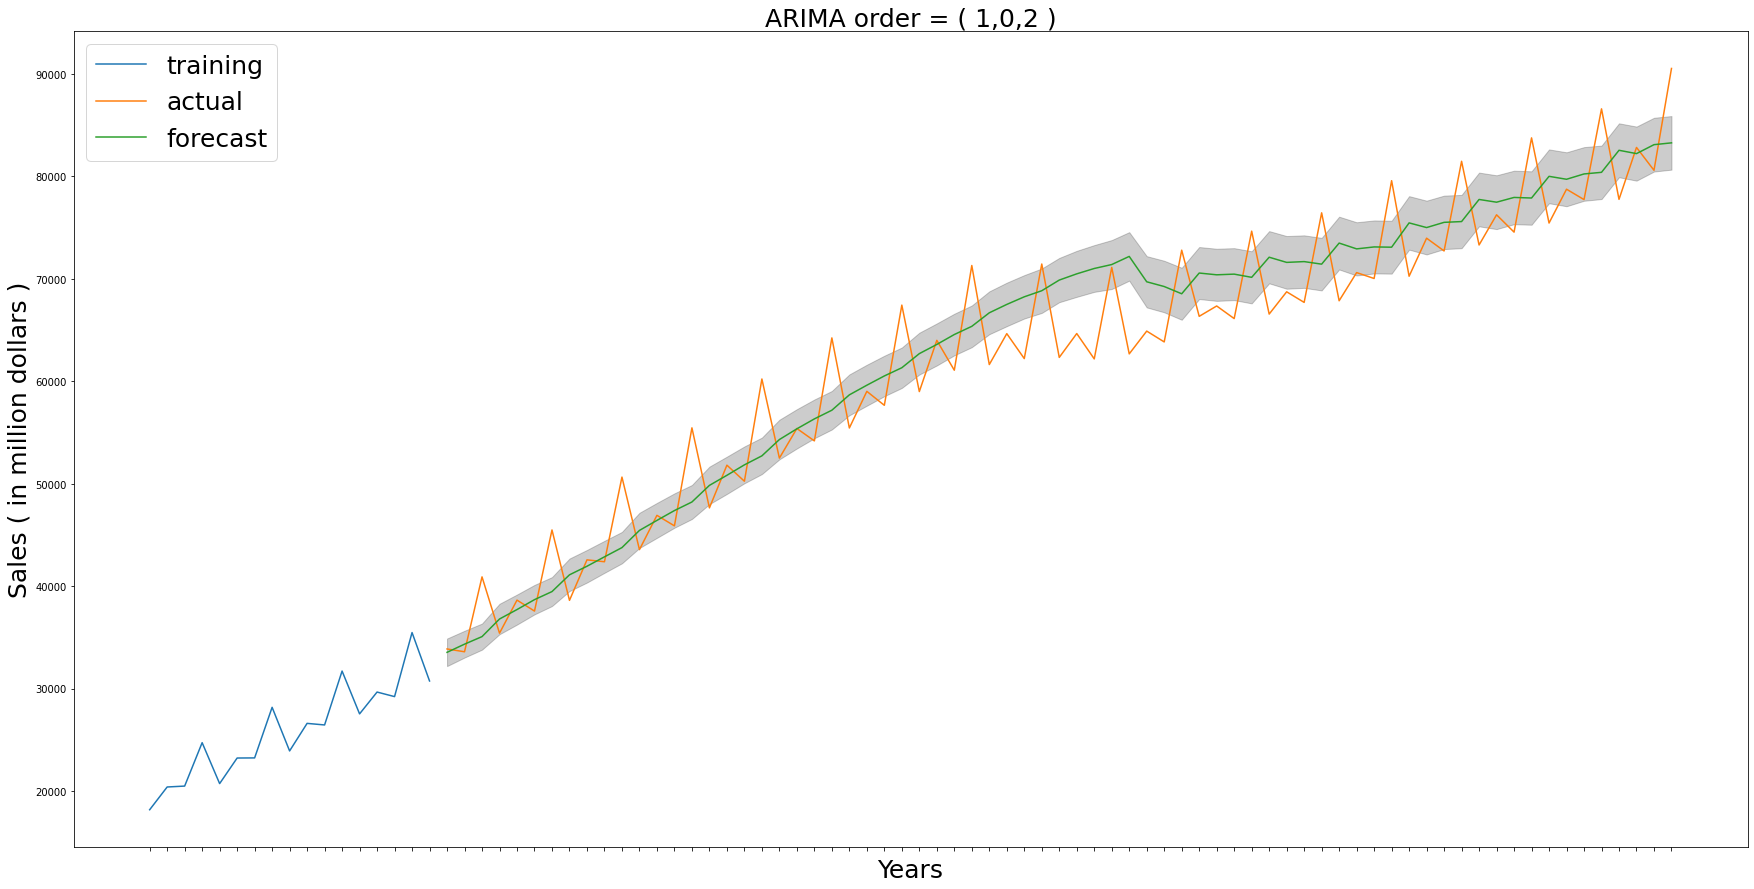

Forecasting accuracy
{
    "mean absolute percentage error": 0.058092343552431855,
    "mean absolute error": 3673.2131853261444,
    "mean squared error": 19082127.390869357,
    "mean percentage error": 0.011964113649257606
}


In [ ]:
# Plotting the predictions.
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(30,15))

# plotting the train data
axs.plot(train_dates, train_data, label='training')

# plotting the actual test data
axs.plot(test_dates, actual_test, label='actual')

# plotting the predicted values
axs.plot(test_dates, forecast_series, label='forecast')

# Plotting the prediction interval.
axs.fill_between(test_dates, lower_series, upper_series, 
                 color='k', alpha=.20)

axs.set_title('ARIMA order = ( 1,0,2 )', fontsize=25)
axs.legend(loc = 'upper left', fontsize=25)
axs.set_ylabel('Sales ( in million dollars )', fontsize=25)
axs.set_xlabel('Years', fontsize=25)
axs.set_xticklabels(axs.get_xticklabels(), rotation=90, fontsize=25)
plt.show()

fig.savefig('ARIMA results.png', dpi=fig.dpi)

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    mse = mean_squared_error(forecast, actual)

    return({'mean absolute percentage error':mape,
            'mean absolute error': mae, 
            'mean squared error':mse,
            'mean percentage error': mpe })

print("Forecasting accuracy")
print(json.dumps(forecast_accuracy(forecast_series, actual_test), indent=4))

In [ ]:
for i in forecast_series:
    print(i)

33546.43795861961
34343.97169938995
35080.89579818418
36798.27608226622
37720.1836741659
38686.94009684274
39474.141828960834
41110.25554174582
41946.91043674849
42864.82469409066
43765.33569779649
45443.25140254223
46421.33114831364
47380.37922816146
48216.702821593375
49836.713735853045
50821.062826512774
51839.56805918088
52719.850765668554
54309.645779037615
55356.70945572426
56325.83369174168
57171.2519966951
58671.003472114826
59611.62403842421
60515.249621759016
61317.100523480185
62693.48307963028
63589.97189924037
64557.768549429646
65356.94331959387
66677.75727469781
67495.41299008529
68238.17704547576
68831.95048779978
69871.31753791582
70478.6807156847
71001.84415259911
71386.6433430581
72181.03919295639
69704.06802637284
69241.62203472032
68534.17141846217
70557.56755646056
70385.19636535888
70451.06198442113
70138.40581527106
72101.70162944408
71596.72071293074
71673.54733736963
71424.94106373991
73481.4187840933
72915.39306176556
73105.61096924896
73079.49162187184
75451